In [1]:
from qiskit import *
#IBMQ.save_account('TOKEN_AQUI')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

from qiskit import BasicAer

from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import clique
from qiskit.aqua.algorithms import ExactEigensolver
#from qiskit.aqua.components.optimizers import SPSA
#from qiskit.aqua.components.variational_forms import RY

from qiskit.tools.visualization import plot_histogram

Using Qiskit Aqua for clique problems

This Qiskit Aqua Optimization notebook demonstrates how to use the VQE quantum algorithm to compute the clique of a given graph.

The problem is defined as follows. A clique in a graph $G$ is a complete subgraph of $G$. We'd like to find a Clique (K), defined by a variable and in a random Graph (G) with vertices (num_nodes) and the same weight_range. 

We will go through three examples to show:

1- How to run the optimization using the declarative approach
2- How to run the optimization using the programmatic approach
3- How how to run the optimization with the VQE.

Note that the solution may not be unique.

[[ 0.  0. -8.  5.  0.  0.  9.  0.]
 [ 0.  0.  0.  0. -3.  0.  6.  0.]
 [-8.  0.  0.  0.  0.  0.  8.  4.]
 [ 5.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -3.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 9.  6.  8.  1.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.]]
{(0, 2): -8.0, (0, 3): 5.0, (0, 6): 9.0, (1, 4): -3.0, (1, 6): 6.0, (2, 6): 8.0, (2, 7): 4.0, (3, 6): 1.0, (4, 5): 1.0}


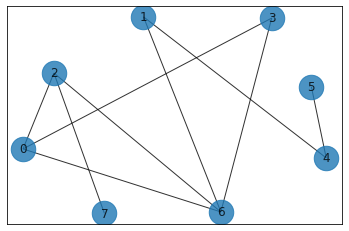

In [35]:
#Start Graph creation and Clique definition
K = 3  # K clique size
np.random.seed(100)
num_nodes = 8 # Graph vertice numbers
adjacency_matrix = clique.random_graph(num_nodes, edge_prob=0.4, weight_range=10)
#Print adjacency matrix
print(adjacency_matrix)

G = nx.from_numpy_matrix(np.array(adjacency_matrix)) 
labels = nx.get_edge_attributes(G,'weight')
#Print edges between vertices
print(labels)

pos = nx.spring_layout(G,k=10,scale=10)

#Print result graph
#nx.draw(G, pos, with_labels=True, width=2, style="solid")
#nx.draw_circular(G, with_labels=True)
nx.draw_networkx(G, with_labels=True, node_size=600, alpha = .8, pos=pos)
#nx.draw_planar(G, with_labels=True)
#nx.draw_random(G, with_labels=True)
#nx.draw_spectral(G, with_labels=True)
#nx.draw_spring(G, with_labels=True)
#nx.draw_shell(G, with_labels=True)


Let us try a brute-force method. Basically, we exhaustively try all the binary assignments. In each binary assignment, the entry of a vertex is either 0 (meaning the vertex is not in the clique) or 1 (meaning the vertex is in the clique). We print the binary assignment that satisfies the definition of the clique (Note the size is specified as K).

Solution is  [1, 0, 0, 1, 0, 0, 1, 0]  for Graph(G) with  8  vertices and a Clique(K):  3


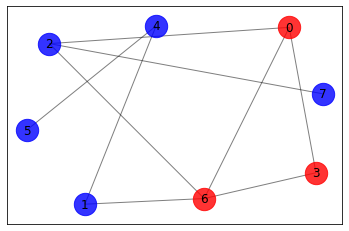

In [39]:
def brute_force():
    # brute-force way: try every possible assignment!
    def bitfield(num_nodes, L):
        result = np.binary_repr(num_nodes, L)
        return [int(digit) for digit in result]
    L = num_nodes  # length of the bitstring that represents the assignment
    max = 2**L
    has_sol = False
    for i in range(max):
        cur = bitfield(i, L)
        cur_v = clique.satisfy_or_not(np.array(cur), adjacency_matrix, K)
        #valor = 0
        #for j in range(num_nodes):
        #    valor = valor + cur[j]
        if (cur_v and np.count_nonzero(cur) == K):
            has_sol = True
            break
        else:
            has_sol = False 
    return has_sol, cur

has_sol, sol = brute_force()

if has_sol:
    print("Solution is ", sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    nol1 = []
    nol2 = []
    #Create two lists to clique vertice colors
    for w in range(num_nodes):
        if sol[w] != 0:
            nol1.append(w)
        else:
            nol2.append(w)
    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Print clique graph
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


Part I: Run the optimization using the declarative approach
Here the steps are:

1- Create the qubit operator i.e. Ising Hamiltonian, using clique ising translator
2- Create an EnergyInput object and a dictionary describing the algorithm and the components for Aqua to solve the problem
3- Run the algorithm and get the result
4- Use the result with the clique object to determine a solution

energy: -3000.75
clique objective: 0.0
Solution is  [1. 0. 0. 1. 0. 0. 1. 0.]  for Graph(G) with  8  vertices and a Clique(K):  3


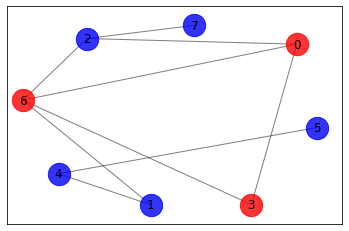

In [52]:
qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)

algo_input = EnergyInput(qubit_op)

params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'ExactEigensolver'}
}
result = run_algorithm(params, algo_input)

print('energy:', result['energy'])
#print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)

x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_sol = clique.get_graph_solution(x)

if clique.satisfy_or_not(ising_sol, adjacency_matrix, K):
    #print("Solution is", ising_sol)
    print("Solution is ", ising_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    ising_nol1 = []
    ising_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_sol[i] != 0:
            ising_nol1.append(i)
        else:
            ising_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)
    


Part II: Run the optimization using the programmatic approach

The main difference here is running the Aqua algorithm. Here we directly construct the algorithm and then run() it to get the result. The post computation on the result is identical.

energy: -3000.75
clique objective: 0.0
Solution is  [1. 0. 0. 1. 0. 0. 1. 0.]  for Graph(G) with  8  vertices and a Clique(K):  3


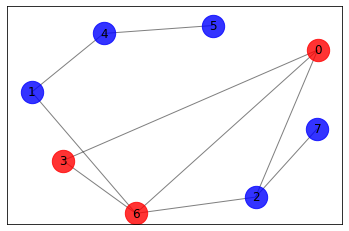

In [53]:
# We will use the qubit_op and offset from above and not re-compute them here
algo = ExactEigensolver(qubit_op)
result = algo.run()

x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
aqua_sol = clique.get_graph_solution(x)

print('energy:', result['energy'])
#print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)

if clique.satisfy_or_not(aqua_sol, adjacency_matrix, K):
    #print("Solution is", aqua_sol)
    print("Solution is ", aqua_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    aqua_nol1 = []
    aqua_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if aqua_sol[i] != 0:
            aqua_nol1.append(i)
        else:
            aqua_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=aqua_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=aqua_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)

Part III: Run the optimization with the VQE

Declarative

We reuse the EnergyInput object we created above. VQE algorithm needs an optimizer and a variational form. Then also we need a quantum backend on which the algorithm will run.

Adjacency Matrix: [[ 0.  0. -8.  5.  0.  0.  9.  0.]
 [ 0.  0.  0.  0. -3.  0.  6.  0.]
 [-8.  0.  0.  0.  0.  0.  8.  4.]
 [ 5.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -3.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 9.  6.  8.  1.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.]]
Clique(K): 3
Execution: 1
ISING: [0. 1. 0. 1. 0. 1. 0. 0.]
Execution  1 time: 41.9059317111969
Execution: 2
ISING: [0. 1. 0. 0. 1. 0. 0. 1.]
Execution  2 time: 41.319456577301025
Execution: 3
ISING: [0. 1. 1. 0. 1. 0. 0. 0.]
Execution  3 time: 36.208675384521484
Execution: 4
ISING: [0. 0. 1. 0. 1. 0. 1. 0.]
Execution  4 time: 37.02535080909729
Execution: 5
ISING: [0. 1. 0. 0. 1. 0. 1. 0.]
Execution  5 time: 35.3297233581543
Execution: 6
ISING: [0. 0. 1. 0. 1. 0. 1. 0.]
Execution  6 time: 35.42522430419922
Execution: 7
ISING: [0. 1. 0. 1. 0. 0. 1. 0.]
Execution  7 time: 35.5468647480011
Execution: 8
ISING: [0. 0. 0. 1. 0. 1. 0. 1.]
Execution  8 time: 36.05254411697388
Execution: 9
ISING: [0. 1

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


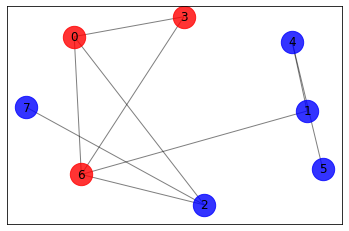

In [49]:
params = {
    'problem': {'name': 'ising'}, #'random_seed': 10598},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA','maxiter': 200},
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}
backend = BasicAer.get_backend('statevector_simulator', shots=10000)
contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

getclique=False
totaltime=0

while not getclique:
    contExec= contExec+1
    print ("Execution:", contExec)
    result = run_algorithm(params, algo_input, backend=backend)
    x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
    ising_vqed_sol = clique.get_graph_solution(x)
    print("ISING:", ising_vqed_sol)
    getclique = clique.satisfy_or_not(ising_vqed_sol, adjacency_matrix, K)
    if np.count_nonzero(ising_vqed_sol) != K:
        getclique = False
    totaltime=totaltime+result['eval_time']
    print("Execution ", contExec, "time:",  result['eval_time'])

print('energy:', result['energy'])
print('time:', totaltime)
print('Total Executions:', contExec)
print('clique objective:', result['energy'] + offset)
#print('solution:', clique.get_graph_solution(x))

if getclique:
    print("Solution is ", ising_vqed_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    ising_vqed_nol1 = []
    ising_vqed_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_vqed_sol[i] != 0:
            ising_vqed_nol1.append(i)
        else:
            ising_vqed_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


Programmatic

We can create the objects directly ourselves too and run VQE for the result

Adjacency Matrix: [[ 0.  0. -8.  5.  0.  0.  9.  0.]
 [ 0.  0.  0.  0. -3.  0.  6.  0.]
 [-8.  0.  0.  0.  0.  0.  8.  4.]
 [ 5.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -3.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 9.  6.  8.  1.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.]]
Clique(K): 3
Execution: 1
ISING: [0. 1. 0. 0. 1. 0. 1. 0.]
Execution  1 time: 43.65322184562683
Get_Result:  {1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 1.0, 8: 0.0}
Execution: 2
ISING: [0. 0. 1. 1. 0. 0. 1. 0.]
Execution  2 time: 40.80582594871521
Get_Result:  {1: 0.0, 2: 0.0, 3: 1.0, 4: 1.0, 5: 0.0, 6: 0.0, 7: 1.0, 8: 0.0}
Execution: 3
ISING: [0. 1. 1. 0. 1. 0. 1. 0.]
Execution  3 time: 43.319674015045166
Get_Result:  {1: 0.0, 2: 1.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 1.0, 8: 0.0}
Execution: 4
ISING: [0. 0. 1. 0. 1. 0. 0. 1.]
Execution  4 time: 47.67898631095886
Get_Result:  {1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 0.0, 8: 1.0}
Execution: 5
ISING: [0. 0. 0. 0. 1. 0. 1. 1

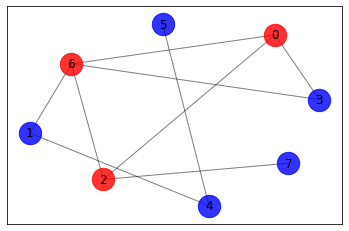

In [41]:
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA #SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)

algo_input = EnergyInput(qubit_op)
#aqua_globals.random_seed = 10598
#seed = 10598
optimizer = COBYLA(maxiter=200)
#optimizer = SPSA(max_trials=200)
var_form = RY(qubit_op.num_qubits, depth=5, entanglement='linear')
vqe_clique = VQE(qubit_op, var_form, optimizer)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=10000) #, seed_simulator=seed)

#result = vqe_clique.run(backend)

contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

getclique=False
totaltime=0

while not getclique:
    contExec= contExec+1
    print ("Execution:", contExec)
    result = vqe_clique.run(quantum_instance)
    x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
    ising_vqep_sol = clique.get_graph_solution(x)
    print("ISING:", ising_vqep_sol)
    getclique = clique.satisfy_or_not(ising_vqep_sol, adjacency_matrix, K)
    if np.count_nonzero(ising_vqep_sol) != K:
        getclique = False
    totaltime=totaltime+result['eval_time']
    print("Execution ", contExec, "time:",  result['eval_time'])
    #print("Get_Result: ", clique.get_gset_result(x))

print('energy:', result['energy'])
print('time:', totaltime)
print('Total Executions:', contExec)
print('clique objective:', result['energy'] + offset)
print('optimal_cost:', vqe_clique.get_optimal_cost())
#print("VQE_ISING:", ising_vqep_sol)
#print('solution:', clique.get_graph_solution(x))

if getclique:
    #if clique.satisfy_or_not(ising_vqep_sol, adjacency_matrix, K):
    #print("Solution is", ising_vqep_sol)
    print("Solution is ", ising_vqep_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)

    #Start lists
    ising_vqep_nol1 = []
    ising_vqep_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_vqep_sol[i] != 0:
            ising_vqep_nol1.append(i)
        else:
            ising_vqep_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqep_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqep_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol)


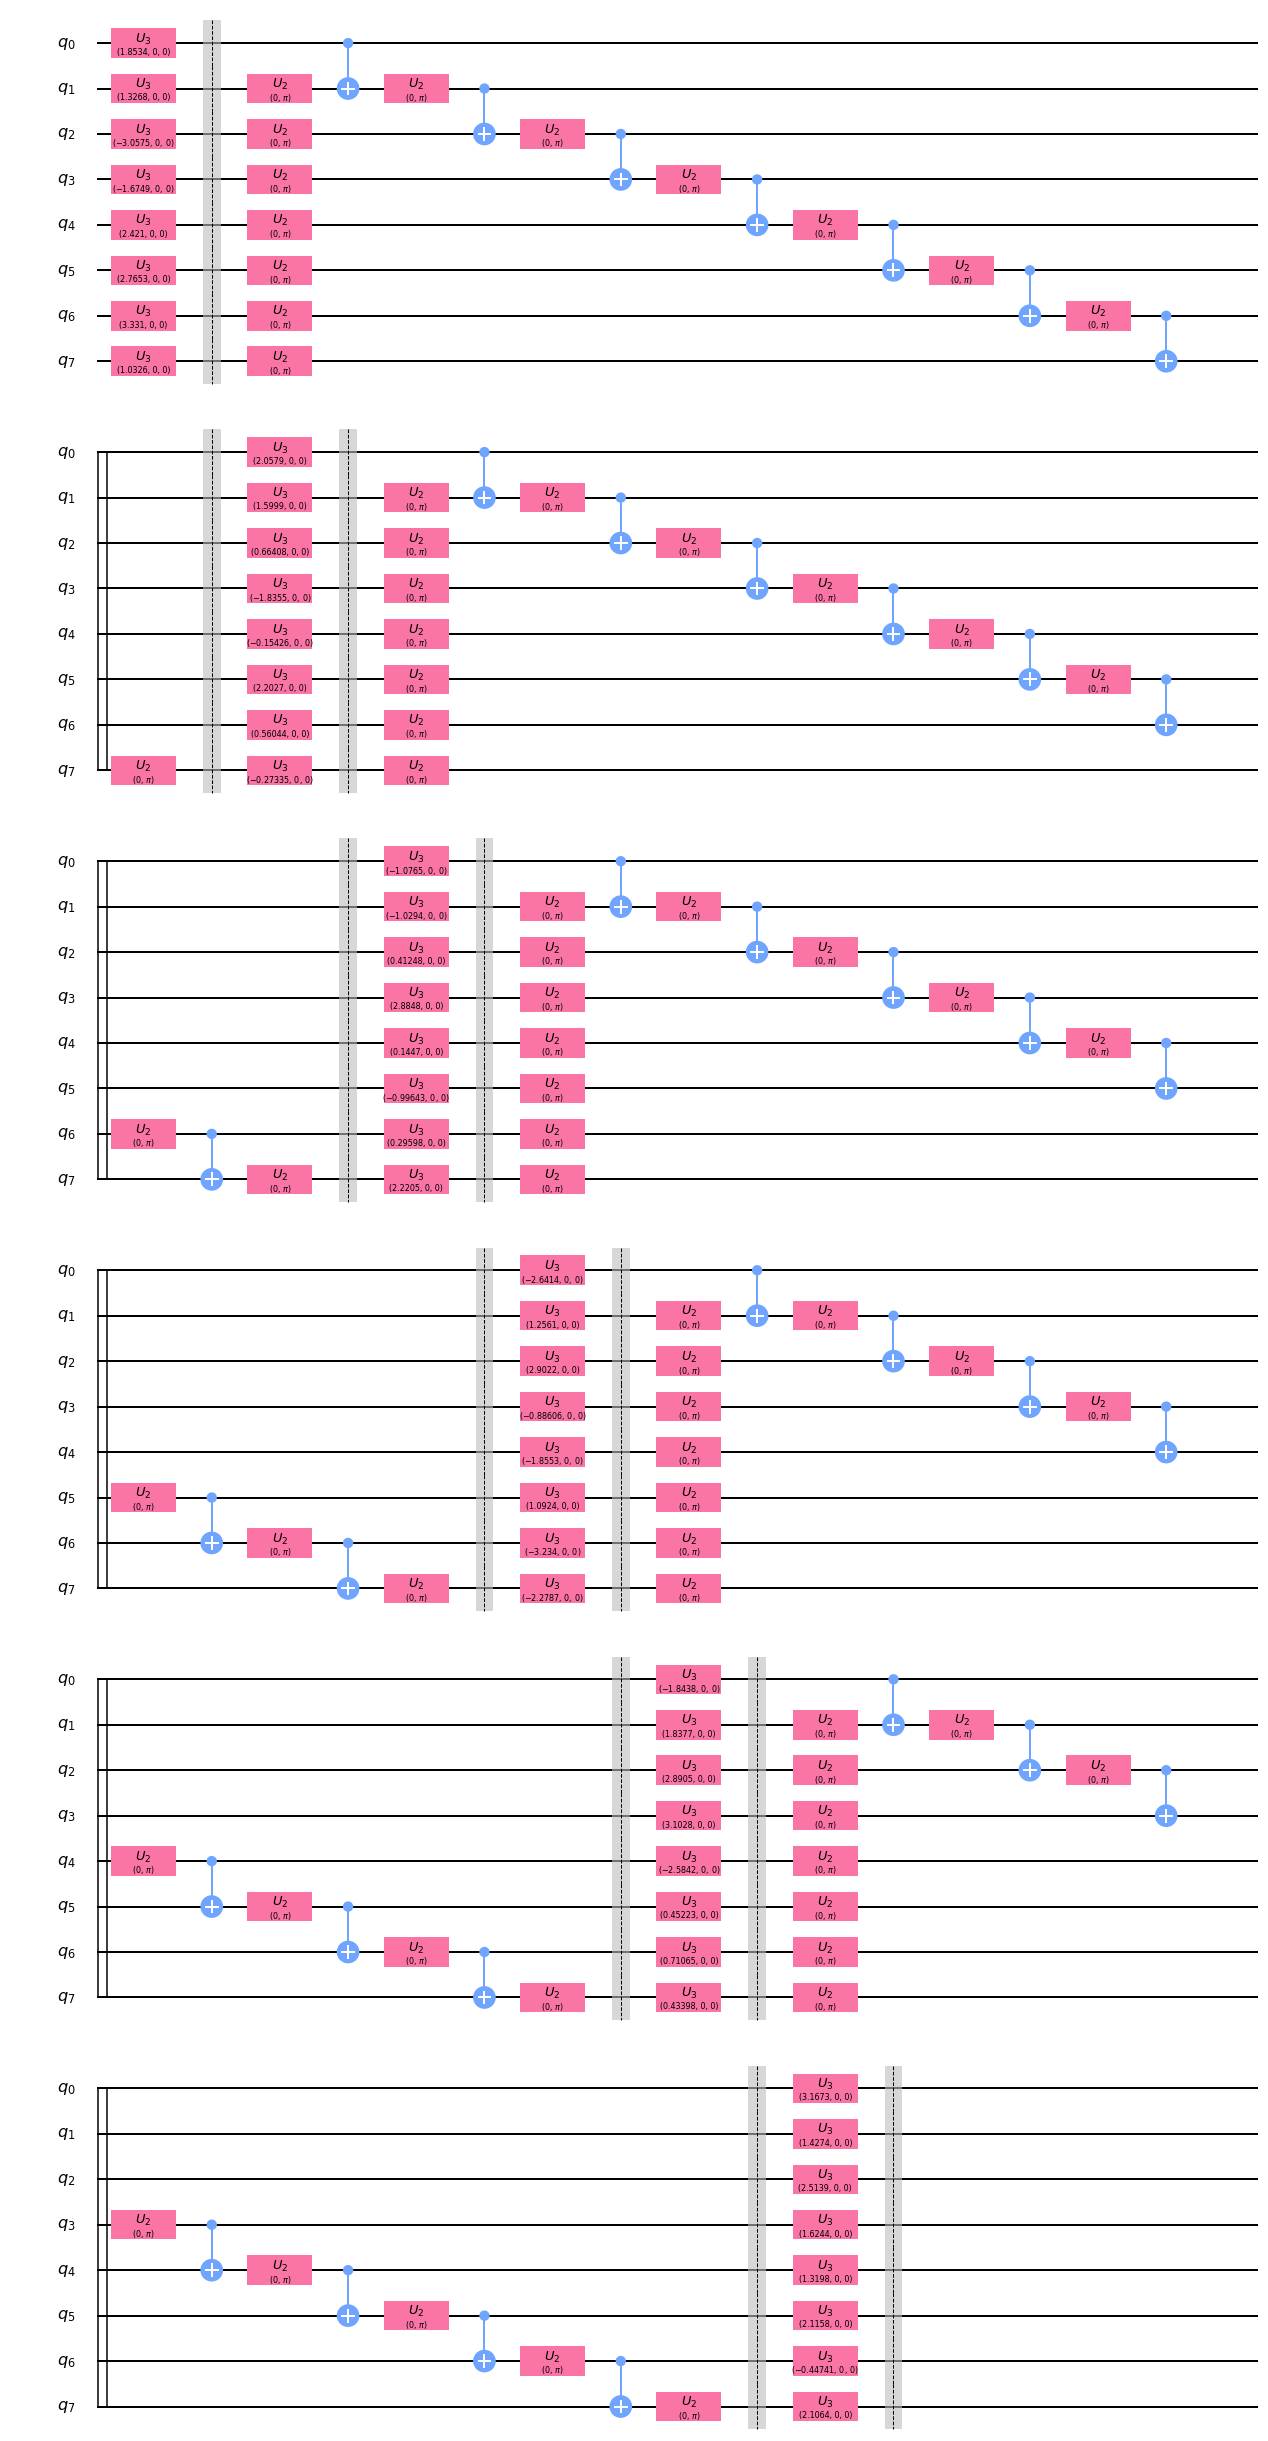

In [55]:
from qiskit.tools.visualization import circuit_drawer

#vqe_clique.print_settings()
#vqe_clique.construct_circuit(parameter=np.array(adjacency_matrix),backend=backend)
#,use_simulator_operator_mode=False, statevector_mode=None, circuit_name_prefix='')

#circuit_drawer(vqe_clique.get_optimal_circuit())

vqe_clique.get_optimal_circuit().draw(output='mpl')


In [51]:
vqe_clique.get_optimal_vector()
#plot_histogram(counts)

array([ 4.93380003e-05+0.00000000e+00j, -1.26917398e-04+0.00000000e+00j,
        4.20755910e-05+0.00000000e+00j, -2.48173894e-04+0.00000000e+00j,
        3.81487647e-04+0.00000000e+00j, -8.88429719e-04+0.00000000e+00j,
        6.95064658e-06+0.00000000e+00j, -1.49945438e-04+0.00000000e+00j,
       -3.38540329e-05+0.00000000e+00j,  1.84701372e-03+0.00000000e+00j,
       -4.53270630e-03+0.00000000e+00j,  7.37002386e-04+0.00000000e+00j,
       -1.51441037e-03+0.00000000e+00j,  6.59412237e-04+0.00000000e+00j,
        5.54891112e-04+0.00000000e+00j,  5.21952393e-04+0.00000000e+00j,
       -1.49308496e-04+0.00000000e+00j,  1.30893470e-04+0.00000000e+00j,
        5.08931244e-05+0.00000000e+00j,  2.27674159e-04+0.00000000e+00j,
       -3.98792170e-04+0.00000000e+00j,  8.79851926e-04+0.00000000e+00j,
       -3.01905134e-04+0.00000000e+00j,  2.05019434e-04+0.00000000e+00j,
        6.30820835e-06+0.00000000e+00j, -1.63926193e-03+0.00000000e+00j,
        4.16477623e-03+0.00000000e+00j, -6.81291924

Adjacency Matrix: [[ 0.  0. -8.  5.  0.  0.  9.  0.]
 [ 0.  0.  0.  0. -3.  0.  6.  0.]
 [-8.  0.  0.  0.  0.  0.  8.  4.]
 [ 5.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -3.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 9.  6.  8.  1.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.]]
Clique(K): 3
Execution: 1
ISING: [1. 0. 1. 0. 0. 1. 0. 0.]
Execution  1 time: 164.7839617729187
Execution: 2
ISING: [0. 1. 0. 1. 0. 1. 0. 0.]
Execution  2 time: 167.57362747192383
Execution: 3
ISING: [0. 0. 1. 1. 0. 1. 1. 0.]
Execution  3 time: 163.14021611213684
Execution: 4
ISING: [0. 1. 0. 0. 1. 0. 1. 0.]
Execution  4 time: 163.9806773662567
Execution: 5
ISING: [0. 0. 1. 0. 1. 0. 1. 0.]
Execution  5 time: 166.1969759464264
Execution: 6
ISING: [0. 0. 1. 0. 1. 1. 0. 0.]
Execution  6 time: 178.1470890045166
Execution: 7
ISING: [1. 0. 1. 0. 0. 1. 0. 0.]
Execution  7 time: 176.68618249893188
Execution: 8
ISING: [0. 0. 1. 0. 1. 1. 0. 0.]
Execution  8 time: 179.0235755443573
Execution: 9
ISING: [

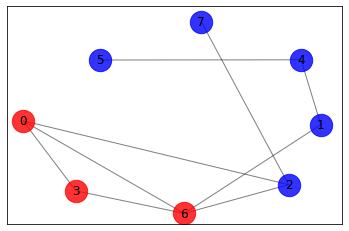

In [54]:
#Célula para testes do código - Declarative VQE
qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)

algo_input = EnergyInput(qubit_op)

params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA'},
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}
backend = BasicAer.get_backend('statevector_simulator')
contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

getclique=False
totaltime=0

while not getclique:
    contExec= contExec+1
    print ("Execution:", contExec)
    result = run_algorithm(params, algo_input, backend=backend)
    x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
    ising_vqed_sol = clique.get_graph_solution(x)
    print("ISING:", ising_vqed_sol)
    getclique = clique.satisfy_or_not(ising_vqed_sol, adjacency_matrix, K)
    if np.count_nonzero(ising_vqed_sol) != K:
        getclique = False
    totaltime=totaltime+result['eval_time']
    print("Execution ", contExec, "time:",  result['eval_time'])

print('energy:', result['energy'])
print('time:', totaltime)
print('Total Executions:', contExec)
print('clique objective:', result['energy'] + offset)
#print('solution:', clique.get_graph_solution(x))

if getclique:
    print("Solution is ", ising_vqed_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    ising_vqed_nol1 = []
    ising_vqed_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_vqed_sol[i] != 0:
            ising_vqed_nol1.append(i)
        else:
            ising_vqed_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


Adjacency Matrix: [[ 0.  0. -8.  5.  0.  0.  9.  0.]
 [ 0.  0.  0.  0. -3.  0.  6.  0.]
 [-8.  0.  0.  0.  0.  0.  8.  4.]
 [ 5.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -3.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 9.  6.  8.  1.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  0.  0.  0.]]
Clique(K): 3
Execution: 1
ISING: [0. 1. 0. 1. 0. 1. 0. 0.]
Execution  1 time: 179.69260835647583
energy: -2997.1824564681674
time: 179.69260835647583
Total Executions: 1
clique objective: 3.567543531832598
Solution is  [0. 1. 0. 1. 0. 1. 0. 0.]  for Graph(G) with  8  vertices and a Clique(K):  3


{0: Text(-9.352544354793112, 3.3170006365939204, '0'),
 1: Text(-2.911271427493821, -9.560987672079197, '1'),
 2: Text(9.877988876656795, -3.2175081445546065, '2'),
 3: Text(2.8248777020118725, 8.910433203285903, '3'),
 4: Text(4.75135906719005, -9.02385607965726, '4'),
 5: Text(-5.1969082723886295, 10.0, '5'),
 6: Text(9.481925717562042, 4.698131311205161, '6'),
 7: Text(-9.475427308745198, -5.123213254793921, '7')}

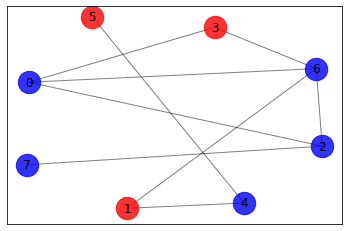

In [56]:
#Code Cell Test - Declarative VQE without Looping
qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)

algo_input = EnergyInput(qubit_op)

params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA'},
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}
backend = BasicAer.get_backend('statevector_simulator')
contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

totaltime=0

result = run_algorithm(params, algo_input, backend=backend)
x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_vqed_sol = clique.get_graph_solution(x)
print("ISING:", ising_vqed_sol)
getclique = clique.satisfy_or_not(ising_vqed_sol, adjacency_matrix, K)
totaltime=totaltime+result['eval_time']

print('energy:', result['energy'])
print('time:', totaltime)
print('clique objective:', result['energy'] + offset)
#print('solution:', clique.get_graph_solution(x))

#if getclique:
print("Solution is ", ising_vqed_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
#Start lists
ising_vqed_nol1 = []
ising_vqed_nol2 = []
#Create two lists to clique vertice colors
for i in range(num_nodes):
    if ising_vqed_sol[i] != 0:
        ising_vqed_nol1.append(i)
    else:
        ising_vqed_nol2.append(i)

pos=nx.spring_layout(G,k=10,scale=10)
#Red color for clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqed_nol1,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#Blue color for not clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqed_nol2,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#Imprimir o grafo com as cliques
nx.draw_networkx_labels(G,pos,with_labels=True)
#else:
#    print("No solution found for K=", K)
